In [1]:
from keras.layers import Input,Dense,Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
from matplotlib import pyplot as plt
import warnings
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from PIL import Image
import scipy.io
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore',category=FutureWarning)



## 1. preprocess pictures
1. resize the pic to 224,224
2. normalize by 224
2. import label- create matrix with categorical reperesenation of each picture's label
4. split to train validation and test data sets
5. Augmente a synthity picture by rotation, shift, zoom and flip manipulations. the synthetic data were added to the train data set


In [2]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with Image.open(file_path) as img:
            # Resize, normalize, and convert the image to a NumPy array
            img = img.resize((224, 224))  # Resize to desired size
            img = np.array(img)  # Convert to NumPy array
            img = img / 255.0  # Normalize pixel values to range [0, 1]
            images.append(img)
    return np.array(images)

In [3]:
#import data
folder_path = "Data/jpg/"
X = load_images_from_folder(folder_path)
#process the target
mat_data = scipy.io.loadmat('Data\imagelabels.mat')
y=mat_data['labels'].flatten()
Y = to_categorical(y, 103)


In [4]:
# Split the data into training, validation, and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)


In [5]:
# Create an instance of the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=180,  # Randomly rotate images by up to 180 degrees
    width_shift_range=0.3,  # Randomly shift images horizontally by up to 30% of the total width
    height_shift_range=0.3,  # Randomly shift images vertically by up to 30% of the total height
    zoom_range=0.2,  # Randomly zoom images by up to 30%
    horizontal_flip=True  # Randomly flip images horizontally
)

# Generate augmented data from the training dataset
augmented_images = []
for i in range(X_train.shape[0]):
    img = X_train[i]
    # Reshape the image to meet the requirements of the ImageDataGenerator
    img = img.reshape((1,) + img.shape)
    # Generate augmented images
    seed = np.random.randint(1, 1000)  # Generate a random seed for each image
    aug_img_gen = datagen.flow(img, batch_size=1, seed=seed)
    augmented_images.append(next(aug_img_gen)[0])

# Convert the augmented data to NumPy array
augmented_images = np.array(augmented_images)

# Concatenate the augmented data with the original training data
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
Y_train_augmented = np.concatenate((Y_train, Y_train), axis=0)

## 2. Deep Learning Model Implemantation

we implement a new model , we use trnafer learning and  use th VGG19 trained model, while we freeze the layer execpt, then we add the output layer which contain 103 outputs , for each prediction. we define the coptimize and the loss function as Adam and categorical_crossentropy and define the metric as accuary.

In [6]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [7]:
#define model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
# Create a new model by adding a custom classification head on top of the VGG19 base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(103, activation='softmax'))  # Use softmax activation for multi-class classification
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train_augmented, Y_train_augmented, validation_data=(X_val, Y_val), epochs=10, batch_size=8)


Epoch 1/10
1029/1029 [==============================] - 1372s 1s/step - loss: 5.0385 - accuracy: 0.3284 - val_loss: 3.2431 - val_accuracy: 0.5358
Epoch 2/10
1029/1029 [==============================] - 1329s 1s/step - loss: 1.1250 - accuracy: 0.7764 - val_loss: 3.2111 - val_accuracy: 0.5639
Epoch 3/10
1029/1029 [==============================] - 1275s 1s/step - loss: 0.9221 - accuracy: 0.8318 - val_loss: 3.7316 - val_accuracy: 0.5733
Epoch 4/10
1029/1029 [==============================] - 1252s 1s/step - loss: 0.7510 - accuracy: 0.8700 - val_loss: 5.0205 - val_accuracy: 0.5229
Epoch 5/10
1029/1029 [==============================] - 1254s 1s/step - loss: 0.7568 - accuracy: 0.8793 - val_loss: 3.3217 - val_accuracy: 0.6290
Epoch 6/10
1029/1029 [==============================] - 1264s 1s/step - loss: 0.5758 - accuracy: 0.9102 - val_loss: 3.9406 - val_accuracy: 0.6127
Epoch 7/10
1029/1029 [==============================] - 1254s 1s/step - loss: 0.5504 - accuracy: 0.9192 - val_loss: 5.3304 -

In [ ]:
history

64/64 [==============================] - 259s 4s/step - loss: 2.8429 - accuracy: 0.6611
Test Loss: 2.842897415161133
Test Accuracy: 0.6611328125


## 3. Evaluation
we show the  test result and the training\validation accuracy and loss as function of epochs

In [10]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

64/64 [==============================] - 247s 4s/step - loss: 5.0102 - accuracy: 0.6182
Test Loss: 5.010227203369141
Test Accuracy: 0.6181640625


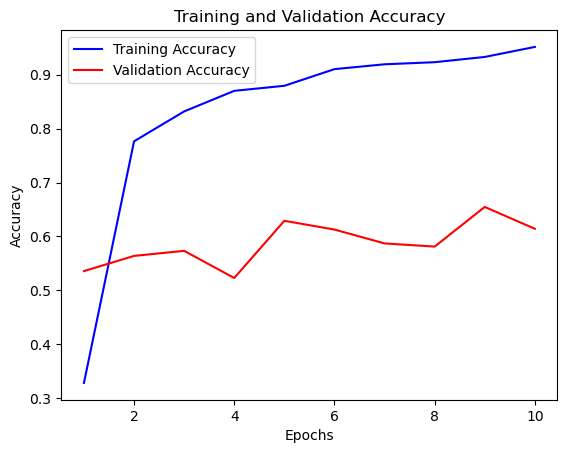

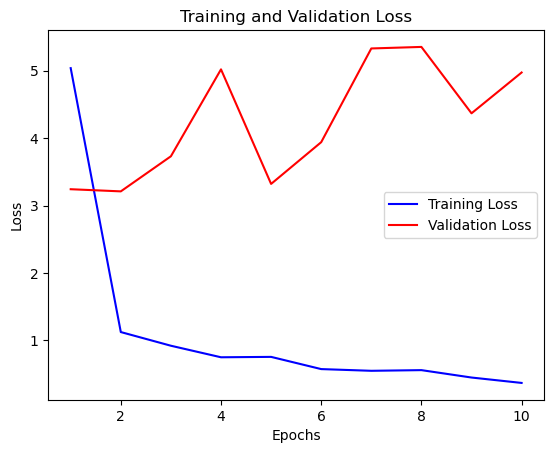

In [11]:

# Extract the accuracy and loss values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the accuracy graph
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the cross-entropy graph
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()